# Lab 1 : First order methods on regression models

#### Authors: A. Gramfort, R. Gower, P. Ablin, M. Massias

## Aim

The aim of this material is to code 
- proximal gradient descent (PGD)
- accelerated gradient descent (APGD) 

for 
- linear regression
- logistic regression 

models.

The proximal operators we will use are the 
- L2 penalization
- L1 penalization

## VERY IMPORTANT

- This work **must be done by pairs of students**.
- **Each** student must send their work using the **moodle platform**. Please check the deadline on moodle!
- This means that **each student in the pair sends the same file**
- The **name of the file must be** constructed as in the next cell

# Gentle reminder: no evaluation if you don't respect this EXACTLY

### How to construct the name of your file

In [ ]:
# Change here using YOUR first and last names
fn1 = "guillaume"
ln1 = "philippe"
fn2 = "max"
ln2 = "wu"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["lab1", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

lab1_philippe_guillaume_and_wu_max.ipynb


In [ ]:
## to embed figures in the notebook
%matplotlib inline

## Part 0 : Introduction

We'll start by generating sparse vectors and simulating data

### Getting sparse coefficients

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(precision=2)  # to have simpler print outputs with numpy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  


Text(0.5, 1.0, 'Parameters / Coefficients')

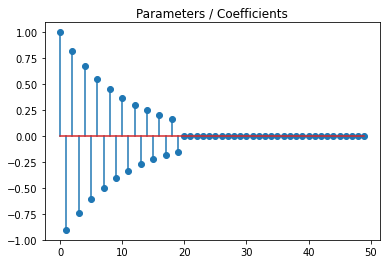

In [ ]:
n_features = 50
n_samples = 1000
idx = np.arange(n_features)
coefs = ((-1) ** idx) * np.exp(-idx / 10.)
coefs[20:] = 0.
plt.stem(coefs)
plt.title("Parameters / Coefficients")

### Functions for the simulation of the models

In [ ]:
from numpy.random import multivariate_normal
from scipy.linalg.special_matrices import toeplitz


def simu_linreg(coefs, n_samples=1000, corr=0.5):
    """Simulation of a linear regression model
    
    Parameters
    ----------
    coefs : `numpy.array`, shape (n_features,)
        Coefficients of the model
    
    n_samples : `int`, default=1000
        Number of samples to simulate
    
    corr : `float`, default=0.5
         Correlation between features i and j is corr^|i - j|


    Returns
    -------
    A : `numpy.ndarray`, shape (n_samples, n_features)
        Simulated features matrix. It samples of a centered Gaussian 
        vector with covariance given by the Toeplitz matrix
    
    b : `numpy.array`, shape (n_samples,)
        Simulated labels
    """
    # Construction of a covariance matrix
    cov = toeplitz(corr ** np.arange(0, n_features))
    # Simulation of features
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    # Simulation of the labels
    b = A.dot(coefs) + np.random.randn(n_samples)
    return A, b


def sigmoid(t):
    """Sigmoid function"""
    return 1. / (1. + np.exp(-t))


def simu_logreg(coefs, n_samples=1000, corr=0.5):
    """Simulation of a logistic regression model
    
    Parameters
    ----------
    coefs : `numpy.array`, shape (n_features,)
        Coefficients of the model
    
    n_samples : `int`, default=1000
        Number of samples to simulate
    
    corr : `float`, default=0.5
        Correlation between features i and j is corr^|i - j|

    Returns
    -------
    A : `numpy.ndarray`, shape (n_samples, n_features)
        Simulated features matrix. It samples of a centered Gaussian 
        vector with covariance given by the Toeplitz matrix
    
    b : `numpy.array`, shape (n_samples,)
        Simulated labels
    """
    cov = toeplitz(corr ** np.arange(0, n_features))
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    p = sigmoid(A.dot(coefs))
    b = np.random.binomial(1, p, size=n_samples)
    b = 2 * b - 1
    return A, b

## Generate the data

In [ ]:
A, b = simu_linreg(coefs)
# A, b = simu_logreg(coefs)  # uncomment when you want to test logistic regression

## Part 1 : Proximal operators

We remind that the proximal operator of a function $R$ is given by:

$$
\text{prox}_{(\lambda \,R)}(x) = \arg\min_z \left\{ \frac{1}{2} \Vert x - z\Vert_2^2 + \lambda \,R(z) \right\}.
$$


We have in mind to use the following cases

- L2 penalization, where $R(z) = \frac{1}{2} \|z\|_2^2$
- L1 penalization, where $R(z) =  \|z|\|_1$

where $\lambda > 0$ is a regularization parameter.

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Code a function that computes $R(x)$ in both cases and $\text{prox}_{\lambda\, R}(x)$ for L2 and  L1 penalization (use the slides of the first course to get the formulas), using the prototypes given below</li>
      <li>Visualize the functions applied element wise by the proximity operators of the L2 and L1 
    </li>
    </ul>
</div>

In [ ]:
from numpy.linalg import norm

def prox_L1(x, lmbd):
    """Proximal operator for the L1 at x"""    
    return np.sign(x) * np.maximum(np.abs(x) - lmbd, 0)
    
def L1_norm(x, lmbd):
    """Value of the L1 penalization at x"""
    return lmbd * norm(x, 1)

def prox_L2(x, lmbd):
    """Proximal operator for the L2 at x"""    
    return x / (1. + lmbd)
    
def L2_norm(x, lmbd):
    """Value of the L2 penalization at x"""
    return lmbd * 1/2 * norm(x, 2) ** 2

## Visualization

We are now going to visualize the effect of the proximity operators on coefficients.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This signific

(-2.0, 2.0)

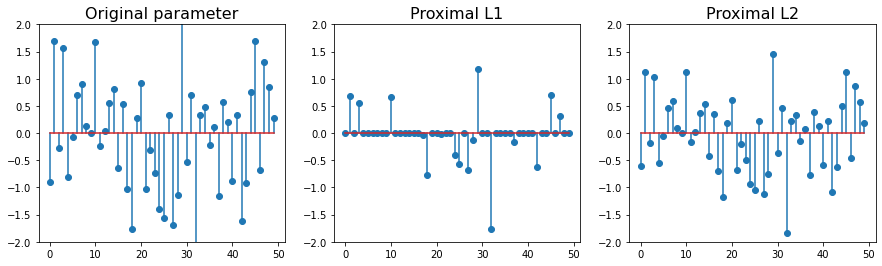

In [ ]:
x = np.random.randn(50)
l_l1 = 1.
l_l2 = 0.5

plt.figure(figsize=(15.0, 4.0))
plt.subplot(1, 3, 1)
plt.stem(x)
plt.title("Original parameter", fontsize=16)
plt.ylim([-2, 2])
plt.subplot(1, 3, 2)
plt.stem(prox_L1(x, lmbd=l_l1))
plt.title("Proximal L1", fontsize=16)
plt.ylim([-2, 2])
plt.subplot(1, 3, 3)
plt.stem(prox_L2(x, lmbd=l_l2))
plt.title("Proximal L2", fontsize=16)
plt.ylim([-2, 2])

<div class="alert alert-success">
    <b>Question</b>:
     <ul>
      <li>Comment what you observe (1 or 2 sentences).</li>
    </ul>
</div>

* For proximal L1, it applies the soft thresholding, values between -λ and λ goes to 0, other values are reduced by λ. We see that the lasso proximal operator introduces sparsity.

* For proximal L2, we divide features by (1 + λ). Opposed to proximal L1, proximal L2 only reduced value by a factor, so we obtain no zero values.

## Part 2: Gradients

The problems we want to minimize take the form:
$$
\arg\min_x f(x) + \lambda \,R(x)
$$
where $f$ is $L$-smooth and $R$ has a simple proximal operator.

Consider the following cases:

**Linear regression**, where 
$$
f(x) = \frac{1}{2n} \sum_{i=1}^n (b_i - a_i^\top x)^2 = \frac{1}{2 n} \| b - A x \|_2^2,
$$
where $n$ is the sample size, $b = [b_1 \cdots b_n]$ is the vector of labels and $A = [a_1,\ldots, a_n]^{\top} \in \mathbb{R}^{n \times d}$ is the matrix of samples.

**Logistic regression**, where
$$
f(x) = \frac{1}{n} \sum_{i=1}^n \log(1 + \exp(-b_i a_i^\top x)),
$$
where $n$ is the sample size, and where labels $b_i \in \{ -1, 1 \}$ for all $i$.

We need to be able to compute $f$ and its gradient

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Compute on paper the gradient $\nabla f$ of $f$ for both cases (linear and logistic regression)</li>
      <li>Code a function that computes $f$ and its gradient $\nabla f$ in both cases, using the prototypes below.</li>
      <li>Check that these functions are correct by numerically checking the gradient, using the function ``<a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.check_grad.html">check_grad</a>`` from ``scipy.optimize``. Remark: use the functions `simu_linreg` and `simu_logreg` to simulate data according to the right model</li>
    </ul>
</div>

**Linear regression gradient**

$$ \nabla f(x) = \frac{A^\top}{n}(Ax-b)$$

**Logisitic regression gradient**

$$ \nabla f(x) = \frac{1}{n} \sum_{i=1}^n \frac{-b_ia_i^\top}{1 + \exp(b_i a_i^\top x)}$$

In [ ]:
def loss_linreg(x):
    """Least-squares loss"""
    n = A.shape[0]
    return 1/(2*n) * np.linalg.norm(b - A@x,2) ** 2

def grad_linreg(x):
    """Least-squares gradient"""
    n = A.shape[0]
    return 1/n * A.T @ (A @ x - b)

def loss_logreg(x):
    """Logistic loss"""
    n = A.shape[0]
    return 1/n * np.sum(np.log(1 + np.exp(-b[..., np.newaxis] * A @ x)))

def grad_logreg(x):
    """Logistic gradient"""
    n = A.shape[0]
    b_exp = np.expand_dims(b, 1)
    return - 1/n * np.sum(b_exp * A / np.expand_dims(np.exp(b_exp * A @ x) + 1, 1), axis=0)

In [ ]:
from scipy.optimize import check_grad

x = np.random.randn(n_features)

A, b = simu_linreg(coefs)
print(check_grad(loss_linreg, grad_linreg, x))

A, b = simu_logreg(coefs)
print(check_grad(loss_logreg, grad_logreg, x))

7.691626023183856e-06
2.2175679424044294e-07


## Part 3: Solvers

We know have a function to compute $f$, $\nabla f$ and $R$ and $\text{prox}_R$. 

We want now to code the PGD and APGD solvers to minimize

$$
\arg\min_x f(x) + \lambda \, R(x)
$$

where $\lambda >0$ is the regularization parameter

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Implement functions that compute the Lipschitz constants for linear and 
  logistic regression losses. Note that the operator norm of a matrix can 
  be computed using the function <a href="https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.norm.html">numpy.linalg.norm</a> (read the documentation
  of the function)</li>
      <li>Finish the functions `PGD` and `APGD` below that implements the 
  PGD(Proximal Gradient Descent) and APGD (Accelerated Proximal 
  Gradient Descent) algorithms</li>
    </ul>
</div>

In [ ]:
from scipy.linalg import eigvalsh
import scipy

# Calculate the smoothness constant for L2 + L2 regularizor
def smoothness_const_linreg(A):
    """Lipschitz constant for linear squares loss"""
    n = A.shape[0] 
    return 1/n * norm(A , ord=2) ** 2
    
# Calculate the smoothness constant for Logistic loss + L2 regularizor    
def smoothness_const_loreg(A):
    """Lipschitz constant for logistic loss"""
    n = A.shape[0]
    return 1/(4*n) * norm(A, ord=2) ** 2
    
def PGD(x0, f, grad_f, R, prox_R, step, lmbd=0., n_iter=50,
         x_true=coefs, verbose=True):
    """Proximal gradient descent algorithm
    """
    x = x0.copy()
    x_new = x0.copy()
    n_samples, n_features = A.shape

    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = norm(x - x_true) / norm(x_true)
    errors.append(err)
    # Current objective
    obj = f(x) + R(x, lmbd)
    objectives.append(obj)
    if verbose:
        print("Lauching PGDsolver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
    for k in range(n_iter + 1):

        x = prox_R(x - (1 / step) * grad_f(x), lmbd / step)
        
        obj = f(x) + R(x, lmbd)
        err = norm(x - x_true) / norm(x_true)
        errors.append(err)
        objectives.append(obj)
        if k % 10 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8), 
                              ("%.2e" % err).rjust(8)]))
    return x, np.array(objectives), np.array(errors)

In [ ]:
def APGD(x0, f, grad_f, R, prox_R, step, lmbd=0., n_iter=50,
         x_true=coefs, verbose=True):
    """Accelerated Proximal gradient descent algorithm
    """
    x = x0.copy()
    x_new = x0.copy()

    beta = 1
    beta_new = 1

    # An extra variable is required for APGD
    z = x0.copy()
    n_samples, n_features = A.shape
    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = norm(x - x_true) / norm(x_true)
    errors.append(err)
    # Current objective
    obj = f(x) + R(x, lmbd)
    objectives.append(obj)
    t = 1.
    t_new = 1.    
    if verbose:
        print("Lauching APGD solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
    for k in range(n_iter + 1):

        x_new = prox_R(z - 1 / step * grad_f(z), lmbd / step)

        beta_new = (1 + np.sqrt(1 + 4 * beta ** 2)) / 2

        z = x_new + (beta - 1) / beta_new * (x_new - x)

        obj = f(x) + R(x, lmbd)
        err = norm(x - x_true) / norm(x_true)
        errors.append(err)
        objectives.append(obj)
        if k % 10 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8), 
                              ("%.2e" % err).rjust(8)]))

        beta = beta_new
        x = x_new
    return x, np.array(objectives), np.array(errors)

## Algorithms comparison and numerical experiments

In [ ]:
# Some definitions before launching the algorithms
x0 = np.zeros(n_features)
n_iter = 300
lmbd = 1e-2

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Compute a precise minimum and a precise minimizer of the linear regression with L2 
  penalization problem using the parameters give above. This can be done by using APGD with 
  1000 iterations.</li>
    <li>Compare the convergences of PGD and APGD, in terms of distance to the minimum and 
  distance to the minimizer. Do your plots using a logarithmic scale of the y-axis.</li>
    </ul>
</div>

In [ ]:
A, b = simu_linreg(coefs)

x_true, obj, err = PGD(x0, loss_linreg, grad_linreg, L2_norm, prox_L2, step=smoothness_const_linreg(A), lmbd=lmbd, n_iter=1000, verbose=False)

In [ ]:
x_1, obj_1, err_1 = PGD(x0, loss_linreg, grad_linreg, L2_norm, prox_L2, step=smoothness_const_linreg(A), lmbd=lmbd, n_iter=n_iter, x_true=x_true)

Lauching PGDsolver...
   it    |   obj    |   err   
       0 | 1.24e+00 | 8.73e-01
      10 | 5.46e-01 | 2.71e-01
      20 | 4.88e-01 | 9.05e-02
      30 | 4.82e-01 | 3.15e-02
      40 | 4.81e-01 | 1.13e-02
      50 | 4.81e-01 | 4.15e-03
      60 | 4.81e-01 | 1.56e-03
      70 | 4.81e-01 | 5.94e-04
      80 | 4.81e-01 | 2.30e-04
      90 | 4.81e-01 | 9.05e-05
     100 | 4.81e-01 | 3.59e-05
     110 | 4.81e-01 | 1.44e-05
     120 | 4.81e-01 | 5.81e-06
     130 | 4.81e-01 | 2.36e-06
     140 | 4.81e-01 | 9.65e-07
     150 | 4.81e-01 | 3.96e-07
     160 | 4.81e-01 | 1.63e-07
     170 | 4.81e-01 | 6.74e-08
     180 | 4.81e-01 | 2.79e-08
     190 | 4.81e-01 | 1.16e-08
     200 | 4.81e-01 | 4.82e-09
     210 | 4.81e-01 | 2.01e-09
     220 | 4.81e-01 | 8.38e-10
     230 | 4.81e-01 | 3.50e-10
     240 | 4.81e-01 | 1.46e-10
     250 | 4.81e-01 | 6.12e-11
     260 | 4.81e-01 | 2.56e-11
     270 | 4.81e-01 | 1.07e-11
     280 | 4.81e-01 | 4.50e-12
     290 | 4.81e-01 | 1.89e-12
     300 | 4.81e-

In [ ]:
x_2, obj_2, err_2 = APGD(x0, loss_linreg, grad_linreg, L2_norm, prox_L2, step=smoothness_const_linreg(A), lmbd=lmbd, n_iter=n_iter, x_true=x_true)

Lauching APGD solver...
   it    |   obj    |   err   
       0 | 1.57e+00 | 1.00e+00
      10 | 4.82e-01 | 4.11e-02
      20 | 4.81e-01 | 1.25e-02
      30 | 4.81e-01 | 5.09e-03
      40 | 4.81e-01 | 2.24e-03
      50 | 4.81e-01 | 1.03e-03
      60 | 4.81e-01 | 4.99e-04
      70 | 4.81e-01 | 2.51e-04
      80 | 4.81e-01 | 1.29e-04
      90 | 4.81e-01 | 6.62e-05
     100 | 4.81e-01 | 3.41e-05
     110 | 4.81e-01 | 1.77e-05
     120 | 4.81e-01 | 9.35e-06
     130 | 4.81e-01 | 5.12e-06
     140 | 4.81e-01 | 2.93e-06
     150 | 4.81e-01 | 1.74e-06
     160 | 4.81e-01 | 1.06e-06
     170 | 4.81e-01 | 6.54e-07
     180 | 4.81e-01 | 4.00e-07
     190 | 4.81e-01 | 2.41e-07
     200 | 4.81e-01 | 1.43e-07
     210 | 4.81e-01 | 8.29e-08
     220 | 4.81e-01 | 4.70e-08
     230 | 4.81e-01 | 2.60e-08
     240 | 4.81e-01 | 1.41e-08
     250 | 4.81e-01 | 7.55e-09
     260 | 4.81e-01 | 4.10e-09
     270 | 4.81e-01 | 2.35e-09
     280 | 4.81e-01 | 1.45e-09
     290 | 4.81e-01 | 9.49e-10
     300 | 4.81

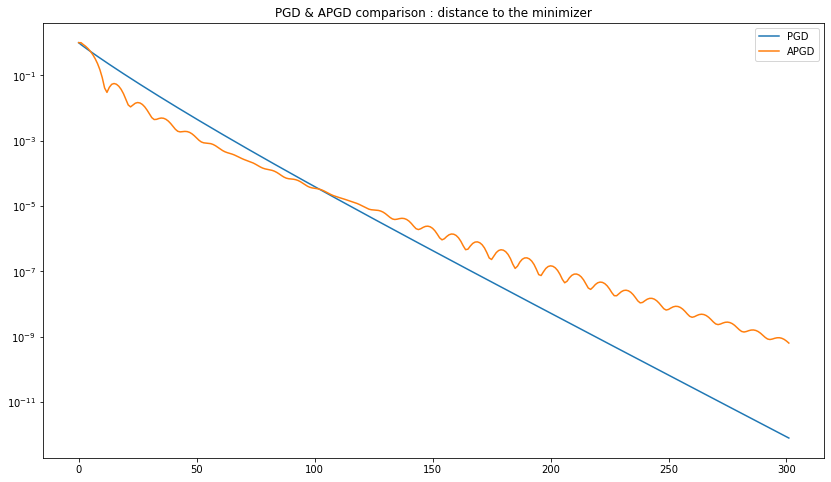

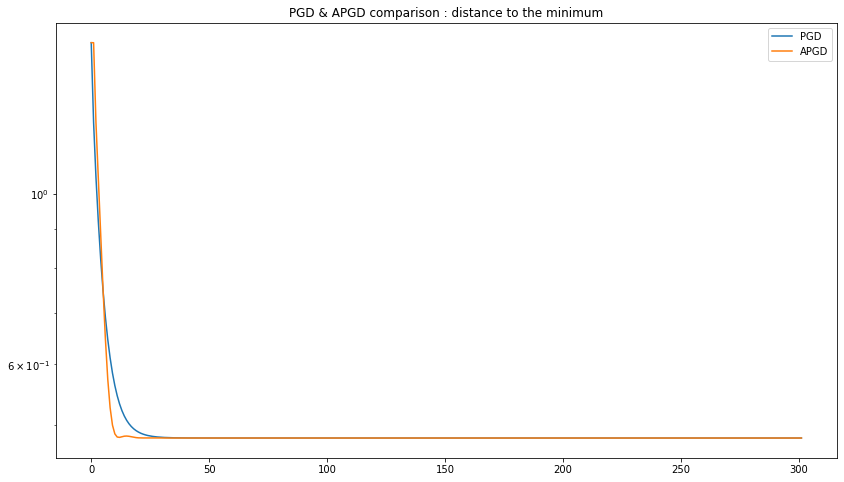

In [ ]:
fig = plt.figure(figsize=(14,8))
plt.title("PGD & APGD comparison : distance to the minimizer")
plt.plot(err_1, label="PGD")
plt.plot(err_2, label="APGD")
plt.yscale("log")
plt.legend()
plt.show()

fig = plt.figure(figsize=(14,8))
plt.title("PGD & APGD comparison : distance to the minimum")
plt.plot(obj_1, label="PGD")
plt.plot(obj_2, label="APGD")
plt.yscale("log")
plt.legend()
plt.show()

 * We obtain a linear convergence with a logarithmic scale of the distance to the minimizer for PGD
 * APGD reaches a plateau at around 10 iterations while PGD reaches a plateau at 30 iterations. 
 * In terms of distance to the minimizer, APGD obtains a better error during the first 100 steps compared to PGD. After hundred of steps, PGD obtains a better error.

<div class="alert alert-success">
    <b>EXERCISE</b>:
     <ul>
      <li>Compare the solution you obtain with PGD and APGD with the true parameter `coefs` of
  the model. This can be done with 3 `plt.stem` plots. Do this for one problem (linear or logistic), but for both regularizers. Comment.</li>
    <li> Pick one problem (logistic or linear) and regularizer (L1 or L2), and study the influence of the correlation 
  of the features on the performance of the optimization algorithms. Explain.</li>
    <li>Pick a different problem (logistic or linear) and a different regularization (L1 or L2), and study the influence of the level of  
  penalization ($\lambda$) on the performance of the optimization algorithms. Explain. Analyse and explain the behavior of the solution vector when $\lambda$ increases.</li>
    </ul>
</div>

## PGD and APGD with the true parameter `coefs` of the model

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plo

(-2.0, 2.0)

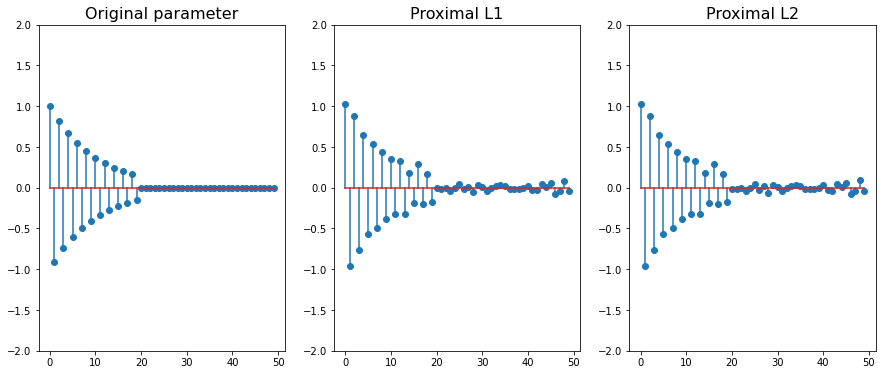

In [ ]:
A, b = simu_linreg(coefs)

plt.figure(figsize=(15.0, 6.0))

plt.subplot(1, 3, 1)
plt.stem(coefs)
plt.title("Original parameter", fontsize=16)
plt.ylim([-2, 2])

x_1, obj_1, err_1 = PGD(x0, loss_linreg, grad_linreg, L1_norm, prox_L1, step=smoothness_const_linreg(A), lmbd=lmbd, n_iter=n_iter, verbose=False)
plt.subplot(1, 3, 2)
plt.stem(x_1)
plt.title("Proximal L1", fontsize=16)
plt.ylim([-2, 2])

x_2, obj_2, err_2 = APGD(x0, loss_linreg, grad_linreg, L2_norm, prox_L2, step=smoothness_const_linreg(A), lmbd=lmbd, n_iter=n_iter, verbose=False)
plt.subplot(1, 3, 3)
plt.stem(x_2)
plt.title("Proximal L2", fontsize=16)
plt.ylim([-2, 2])

Looking at the graphs above, we remark the that parameters obtained with Lasso proximal and Ridge proximal are very similar, even if they are 2 differents methods.

## Influence of the correlation of the features

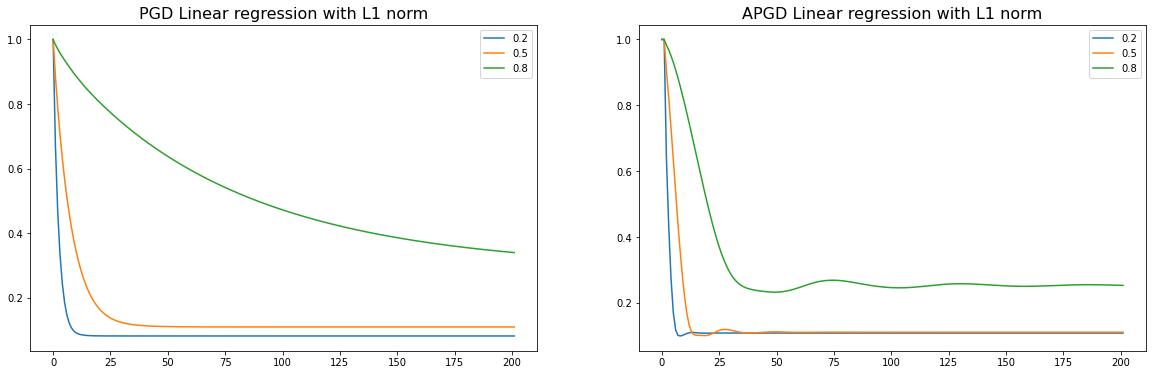

In [ ]:
corrs = [0.2, 0.5, 0.8]

plt.figure(figsize=(20, 6))

for i, method in enumerate([PGD, APGD]):
    plt.subplot(1,2,i+1)
    plt.title(f"{method.__name__} Linear regression with L1 norm", fontsize=16)
    for corr in corrs:
        A, b = simu_linreg(coefs, corr=corr)

        x, obj, err = method(x0, loss_linreg, grad_linreg, L1_norm, prox_L1, step=smoothness_const_linreg(A), lmbd=1e-2, n_iter=200, verbose=False)
        plt.plot(err, label=str(corr))
    plt.legend()

* We observe that we obtain a low error with low correlation of the features. Inversely, when the correlation is high, methods have more difficulty to obtain a low error.

* With a low correlation, PDG and APGD results are very close. However, results are better when using APGD rather than PGD for high correlation.

To conclude, correlation is a critic aspect for convergence of both methods. Correlation has a direct impact on the convergence rate by the Lipschitz constant $L$, which tends to grow with correlation. The conclusions are the same for the logistic regression but only the linear regression with L1 norm results are plot.

## Influence of the level of penalization ( 𝜆 )

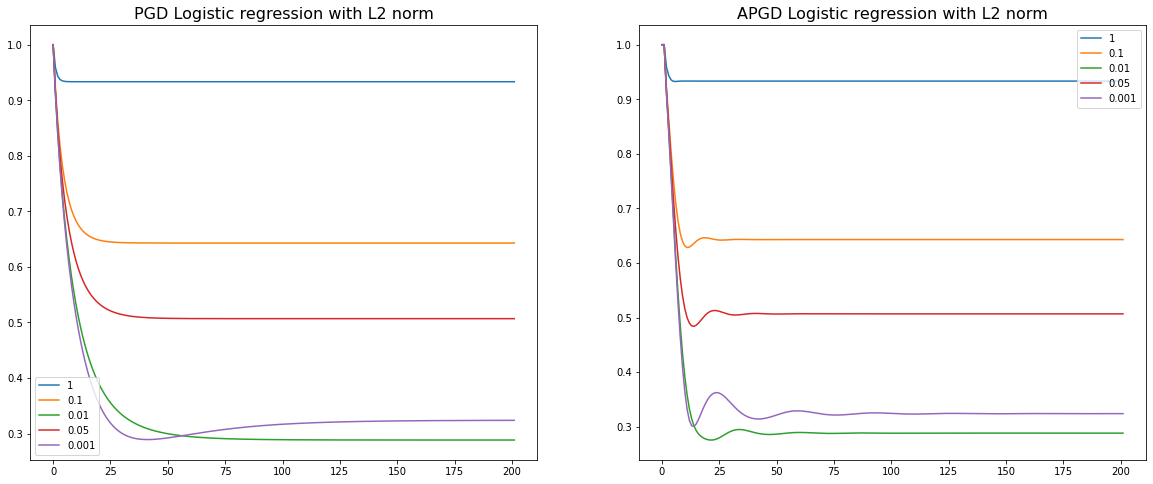

In [ ]:
A, b = simu_logreg(coefs)
n_iter = 200

lmbds = [1, 1e-1, 1e-2, 5e-2, 1e-3]

plt.figure(figsize=(20, 8))

for i, method in enumerate([PGD, APGD]):
    plt.subplot(1,2,i+1)
    plt.title(f"{method.__name__} Logistic regression with L2 norm", fontsize=16)
    for i, lmbd in enumerate(lmbds):
        _, _, err = method(x0, loss_logreg, grad_logreg, L2_norm, prox_L2, step=smoothness_const_loreg(A), lmbd=lmbd, n_iter=n_iter, verbose=False)
        plt.plot(err, label=f"{lmbd}")
    plt.legend()

* We observe that low values tends to give better results. In graphs above, the best result is obtain with a penalization equal to 0.01. However, a level of penalization of 0.05 obtain worse results than level of 0.01 or 0.001.

* Convergence of both methods are very similar for the logistic regression with L2 norm

To conclude, a high level of penalization λ with L2 norm, tends to reduce parameters. In the other case, a low level with L2 norm will give high paramemters. The best penalization will be between this 2 problems. The conclusions are the same for the linear regression but only the logistic regression with L2 norm results are plot.